# Potato Disease Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  # Directory path where the dataset is located
    seed=123,  # Seed for random shuffling of the dataset
    shuffle=True,  # Whether to shuffle the data or not
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  # Desired image size for resizing
    batch_size=BATCH_SIZE  # Number of images in each batch
)

Found 2152 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)  # Prints the shape of the image batch
    print(labels_batch.numpy())  # Prints the labels batch as a NumPy array


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


### Visualize some of the images from our dataset

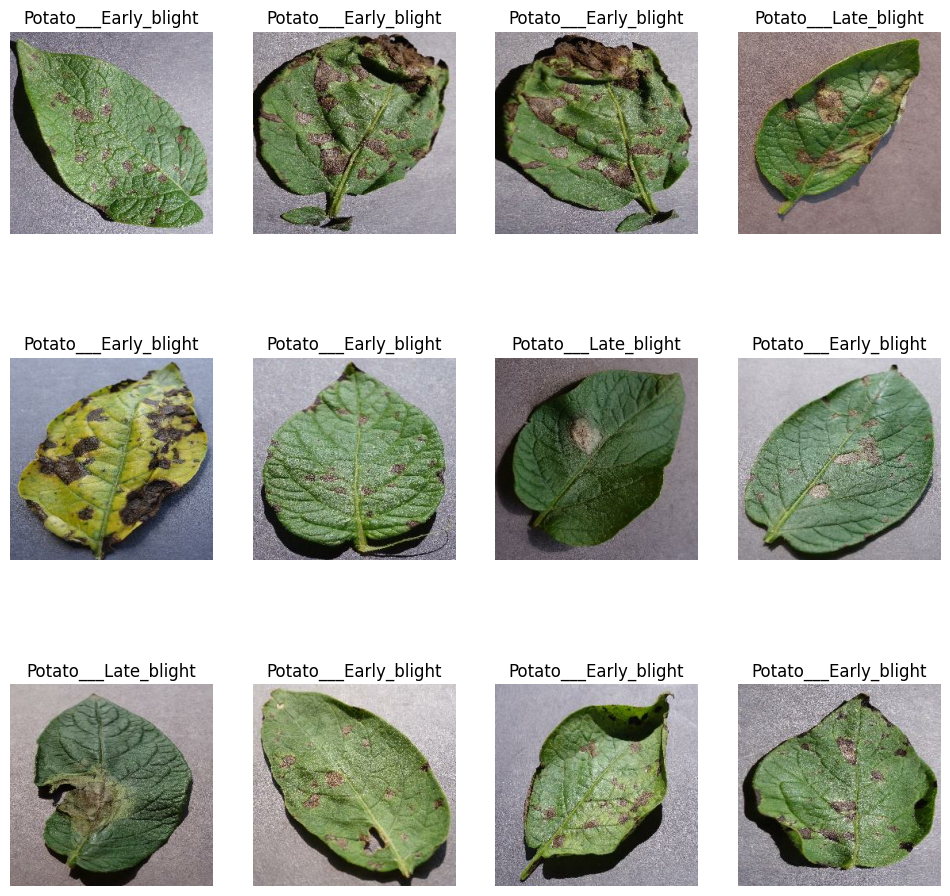

In [15]:
plt.figure(figsize=(12, 12))  # Sets the figure size for the plot

for image_batch, labels_batch in dataset.take(1):  # Iterates over the first batch of images and labels in the dataset
    for i in range(12):  # Iterates over the images in the batch (assumes batch size of 12)
        ax = plt.subplot(3, 4, i + 1)  # Creates a subplot with 3 rows and 4 columns, and selects the i+1th subplot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Displays the i-th image in the batch as a NumPy array
        plt.title(class_names[labels_batch[i]])  # Sets the title of the subplot to the corresponding label from the batch
        plt.axis("off")  # Turns off the axis labels and ticks for the subplot


In [16]:
len(dataset)

68

In [17]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds = dataset.take(516)
len(train_ds)

68

In [19]:
test_ds = dataset.skip(516)
len(test_ds)

0

In [20]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [14]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1  # Ensures that the split ratios add up to 1
    
    ds_size = len(ds)  # Gets the total size of the dataset
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffles the dataset if `shuffle` is True, using a specified `shuffle_size` and seed
    
    train_size = int(train_split * ds_size)  # Calculates the size of the training set based on the split ratio
    val_size = int(val_split * ds_size)  # Calculates the size of the validation set based on the split ratio
    
    train_ds = ds.take(train_size)  # Takes the first `train_size` elements from the shuffled dataset as the training set
    val_ds = ds.skip(train_size).take(val_size)  # Skips the training set elements and takes the next `val_size` elements as the validation set
    test_ds = ds.skip(train_size).skip(val_size)  # Skips the training and validation set elements and takes the rest as the test set
    
    return train_ds, val_ds, test_ds  # Returns the training, validation, and test sets


In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Normalizing the image pixel value (keeping them in range 0 and 1 by dividing by 256) to omprove model performance.

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Randomly flips the input images horizontally and vertically
  layers.experimental.preprocessing.RandomRotation(0.2),  # Randomly applies rotations to the input images within a range of 0.2 radians
])


#### Applying Data Augmentation to Train Dataset

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Defines the input shape of the model
n_classes = 3  # Number of classes in the classification task

model = models.Sequential([
    resize_and_rescale,  # Preprocessing layer for resizing and rescaling the input images
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),  # Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with a 2x2 pool size
    layers.Flatten(),  # Flattens the input tensor
    layers.Dense(64, activation='relu'),  # Fully connected layer with 64 units and ReLU activation
    layers.Dense(n_classes, activation='softmax'),  # Output layer with n_classes units and softmax activation
])

model.build(input_shape=input_shape)  # Builds the model with the specified input shape


In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 205s 4s/step - loss: 0.3080 - accuracy: 0.8762 - val_loss: 0.1878 - val_accuracy: 0.9271
Epoch 2/10
54/54 [==============================] - 204s 4s/step - loss: 0.1594 - accuracy: 0.9387 - val_loss: 0.2380 - val_accuracy: 0.9010
Epoch 3/10
54/54 [==============================] - 201s 4s/step - loss: 0.1789 - accuracy: 0.9288 - val_loss: 0.1265 - val_accuracy: 0.9583
Epoch 4/10
54/54 [==============================] - 229s 4s/step - loss: 0.1290 - accuracy: 0.9462 - val_loss: 0.1143 - val_accuracy: 0.9531
Epoch 5/10
54/54 [==============================] - 171s 3s/step - loss: 0.1055 - accuracy: 0.9572 - val_loss: 0.1595 - val_accuracy: 0.9583
Epoch 6/10
54/54 [==============================] - 177s 3s/step - loss: 0.0866 - accuracy: 0.9624 - val_loss: 0.2815 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 170s 3s/step - loss: 0.0727 - accuracy: 0.9699 - val_loss: 0.2645 - val_accuracy: 0.9167
Epoch 8/10
54

In [35]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 17s 673ms/step - loss: 0.1066 - accuracy: 0.9766


In [36]:
scores

[0.10663267970085144, 0.9765625]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

10

In [43]:
history.history['loss'][:10] # show loss for first 5 epochs

[0.307996541261673,
 0.15936537086963654,
 0.17886899411678314,
 0.12903070449829102,
 0.10554777830839157,
 0.08662427216768265,
 0.07267265766859055,
 0.07096770405769348,
 0.09059372544288635,
 0.07383181899785995]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 929ms/step
predicted label: Potato___Late_blight


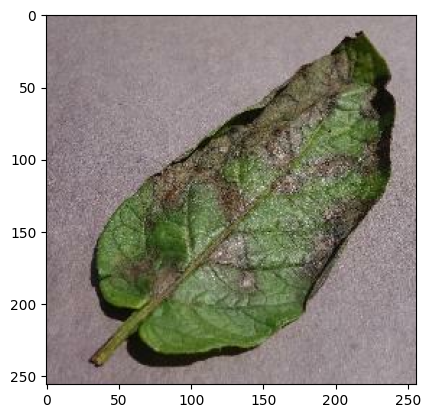

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 42ms/step


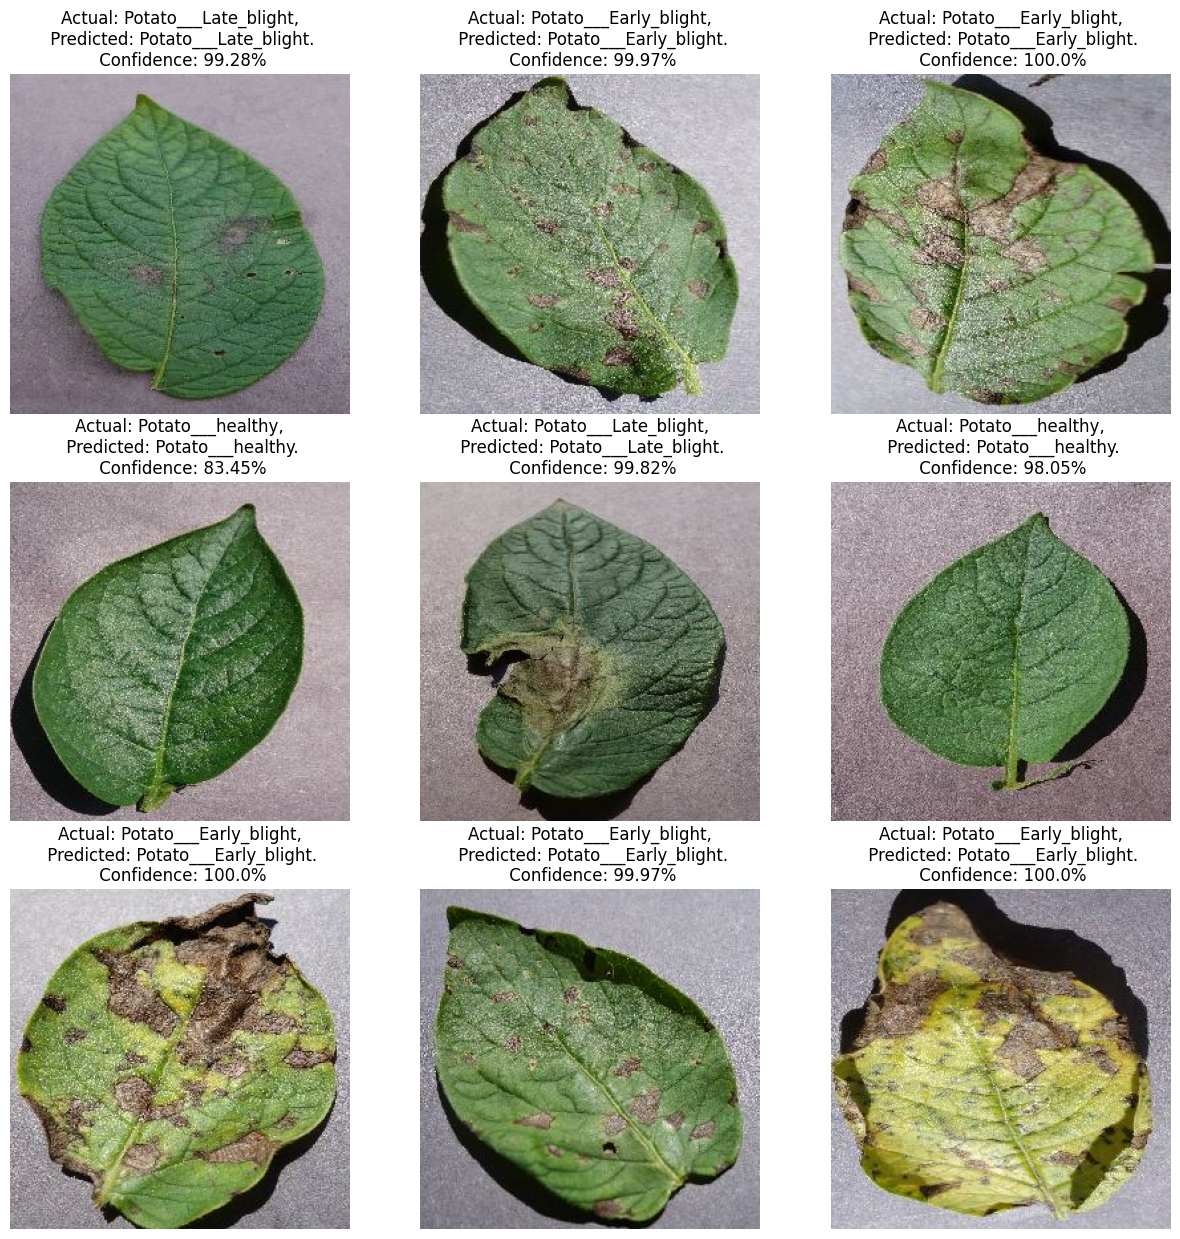

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [53]:
import os
model_version=max([int(i) for i in os.listdir("../models_mine") + [0]])+1
model.save(f"../models_mine/{model_version}")

INFO:tensorflow:Assets written to: ../models_mine/1\assets


INFO:tensorflow:Assets written to: ../models_mine/1\assets


In [48]:
model.save("../potatoes.h5")